## Import Python libary

In [40]:
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import sounddevice as sd
import time
import os
import re
import math
import matplotlib.pyplot as plt
from tensorflow import keras
import webrtcvad # 這個有可能需要額外下載 Microsoft C++ Build Tools 這個是用在VAD那個函數。
# import noisereduce as nr  # 需要額外的pip install torch
# import audiosegment

## Global variables

In [41]:
Speakers = ['Abigail', 'Aiden', 'Ava', 'Benjamin', 'Elijah', 'Emma', 'Ethan', 'Han', 'Harper', 
            'Hua', 'Isabella', 'Jackson', 'Liam', 'Lucas', 'Mia', 'Noah', 'Olivia', 'Patrick', 'Rain', 'Xin']
NumOfSpeakers = 20
NumOfDataOfSpeaker = [] # 儲存每個speaker的音檔數量：[101, 97, 95, 92, 100, 92, 91, 103, 99, 98, 97, 91, 96, 106, 97]
AudioFiles = []  # 包含所有的音檔：[[(y, sr), (y, sr)......], [], []......]
DataFrame = pd.DataFrame()  # 包含所有音檔的DataFrame
training_y = pd.DataFrame()
training_X = pd.DataFrame()            
validation_y = pd.DataFrame()
validation_X = pd.DataFrame()
test_data = [] # 儲存錄音後將聲音轉成音訊的numpy array

## Read files
Read files from dataset and store their y and sr into AudioFiles

In [42]:
def ReadFile(AudioFiles, NumOfDataOfSpeaker):
    base_path = 'dataset'
    for name in os.listdir(base_path):
        name_path = os.path.join(base_path, name)     # name_path = dataset/name
        tmp = []
        cnt = 0
        for file_name in os.listdir(name_path):
            if file_name.endswith('.flac'):
                file_path = os.path.join(name_path, file_name)  # file_path = dataset/name/file_name

                # 判斷音檔長度，大於10秒才保留
                duration = librosa.get_duration(path=file_path)
                if duration < 10: continue
                    
                # 使用librosa加載音頻
                y, sr = librosa.load(file_path, sr=None)
                y = y[:int(sr * 10)]  # 把超過10秒的部分剪掉
                tmp.append((y, sr))
                cnt += 1
                    
        NumOfDataOfSpeaker.append(cnt)
        AudioFiles.append(tmp)

ReadFile(AudioFiles, NumOfDataOfSpeaker)

## VAD and Noise reduction

##### Implement VAD algorithm

In [4]:
# # 這個可以知道音檔資料，因為vad.is_speech這個函數對音檔格式很要求，
# # Sample Rate要是8k、16k、32k
# # Channels要是單聲道
# # Sample Width也規定要是16位元
# def get_audio_info(audio_file):
#     audio_data, sample_rate = sf.read(audio_file)
#     # 獲取音訊資訊
#     sample_width = audio_data.dtype.itemsize * 8  # 計算取樣寬度（以位元表示）
#     n_channels = audio_data.shape[1] if len(audio_data.shape) > 1 else 1  # 計算通道數
#     n_frames = audio_data.shape[0]  # 計算幀數
#     # 輸出音訊資訊
#     # print(f"原音訊資訊：")
#     print(f"取樣率(Sample Rate): {sample_rate}")
#     print(f"取樣寬度(Sample Width): {sample_width}")
#     print(f"通道數(Channels): {n_channels}")
#     print(f"幀數(Frames): {n_frames}")

# # 如果Sample Rate跟Channels不對的話可以用這個轉換一下，但需要一個新的檔案來存這個修改過後的音檔
# def convert_audio(input_file, output_file, target_sample_rate=16000):
#     # 讀取音訊檔案
#     audio_data, sample_rate = sf.read(input_file)

#     # 如果音訊是雙聲道，將其轉換為單聲道
#     if audio_data.ndim > 1:
#         audio_data = audio_data.mean(axis=1)

#     # 計算重取樣後的長度
#     num_samples = round(len(audio_data) * float(target_sample_rate) / sample_rate)

#     # 執行重取樣
#     resampled_audio = resample(audio_data, num_samples)

#     # 寫入重取樣後的音訊檔案
#     sf.write(output_file, resampled_audio, target_sample_rate)


# # 這個主要的功能是吃一段音檔，然後他可以告訴你這段音檔是不是刻意錄音的
# # 如果是那種背景音她會當作是沒有錄音，但背景音也不能太大聲，比如說像是電風扇的聲音她會視作不是語音這樣
# def VAD(audio_file):

#     audio_data, sample_rate = sf.read(audio_file)

#     # 初始化 VAD
#     vad = webrtcvad.Vad()
#     vad.set_mode(3) 

#     # 轉換成 16 位元 PCM 格式
#     audio_data_pcm = (audio_data * (2 ** 15)).astype('int16')

#     # 切割為 10 毫秒片段
#     frame_duration = 10  # 毫秒
#     frame_length = int(sample_rate * (frame_duration / 1000))

#     offset = 0
#     speech_results = []
#     while offset + frame_length < len(audio_data_pcm):
#         frame = audio_data_pcm[offset:offset + frame_length]
#         is_speech = vad.is_speech(frame.tobytes(), sample_rate)
#         speech_results.append(is_speech)
#         offset += frame_length

#     # if any(speech_results):
#     #     print("此音訊檔案包含錄音")
#     # else:
#     #     print("此音訊檔案不包含錄音")
    
#     for i in range(len(speech_results)):
#         speech_results[i] = 1 if speech_results[i] else 0

#     print(f"1是有錄音的片段0沒有: {speech_results}") 

# audio_file = "dataset/Abigail/150-126107-0002.flac"
# get_audio_info(audio_file)
# VAD(audio_file)

In [5]:
# #對我們所有的 data_set 做 VAD，可以用，但會跑一陣子
# def VAD_for_folder(base_path):
#     all_results = []  # 用於存儲所有音檔的結果

#     for person in os.listdir(base_path):
#         person_path = os.path.join(base_path, person)
#         if os.path.isdir(person_path):  # 確保是資料夾
#             person_results = []  # 用於存儲這個人的音檔結果
#             for file_name in os.listdir(person_path):
#                 if file_name.endswith('.flac'):
#                     audio_file = os.path.join(person_path, file_name)
#                     audio_data, sample_rate = sf.read(audio_file)

#                     # 初始化 VAD
#                     vad = webrtcvad.Vad()
#                     vad.set_mode(3) 

#                     # 轉換成 16 位元 PCM 格式
#                     audio_data_pcm = (audio_data * (2 ** 15)).astype('int16')

#                     # 切割為 10 毫秒片段
#                     frame_duration = 10  # 毫秒
#                     frame_length = int(sample_rate * (frame_duration / 1000))

#                     offset = 0
#                     speech_results = []
#                     while offset + frame_length < len(audio_data_pcm):
#                         frame = audio_data_pcm[offset:offset + frame_length]
#                         is_speech = vad.is_speech(frame.tobytes(), sample_rate)
#                         speech_results.append(is_speech)
#                         offset += frame_length

#                     speech_results_numeric = [1 if result else 0 for result in speech_results]
#                     person_results.append(speech_results_numeric)
            
#             all_results.append(person_results)  # 將這個人的結果添加到所有結果中

#     return all_results

# # 資料夾路徑
# A_base_path = 'dataset'

# # 呼叫 VAD_for_folder 函式處理整個資料夾
# results = VAD_for_folder(A_base_path)

# # 印出所有音檔的結果
# for person_results in results:
#     for audio_results in person_results:
#         print(audio_results)  # 每個音檔的結果

##### Implement Noise reduction

In [6]:
# def NoiseReduction(y, sr, audio_channels):
#     # 進行降噪處理
#     reduced_noise = nr.reduce_noise(y, sr)

#     reduced_audio = audiosegment(
#         reduced_noise.tobytes(),
#         frame_rate=sr,
#         sample_width=5,
#         channels=audio_channels
#     )

#     # 將降噪後的音檔保存為新檔案
#     denoised_file_path = "denoised_audio.wav"
#     sf.write(denoised_file_path, reduced_audio, sr)

#     print(f"Denoised audio file saved at: {denoised_file_path}")
#     return reduced_noise

## Extract Features

##### Melspectrograms

In [43]:
def Melspectrogram(y, sr):
    # 計算梅爾頻譜圖
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    # 將梅爾頻譜圖轉換為分貝表示
    log_melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
    return log_melspectrogram

##### MFCC coefficient

In [44]:
def MFCC(y, sr):
    # 提取MFCC參數
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    return mfcc

## Build DataFrame

In [45]:
def BuildDataFrame():
    DataFrame = pd.DataFrame(columns=['Melspectrogram', 'Speaker']) 
    for i in range(NumOfSpeakers):
        for audio_file in AudioFiles[i]:
            data = pd.DataFrame({
                'Melspectrogram': [Melspectrogram(audio_file[0], audio_file[1])], 
                'Speaker': i
            })
            DataFrame = pd.concat([DataFrame, data], ignore_index=True)
    return DataFrame

DataFrame = BuildDataFrame()
DataFrame = DataFrame.sample(frac=1).reset_index(drop=True)

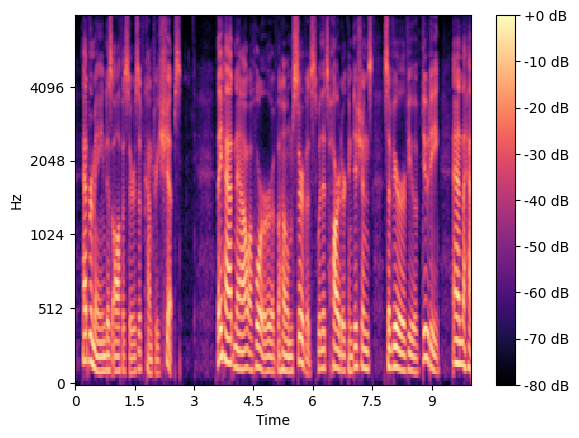

In [46]:
# 顯示梅爾頻譜圖
librosa.display.specshow(DataFrame.at[0, 'Melspectrogram'], sr=AudioFiles[0][0][1], x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

## Split data

In [51]:
def Split_training_and_validation(y, X):
    training_y = pd.DataFrame() 
    training_X = pd.DataFrame()
    validation_y = pd.DataFrame()
    validation_X = pd.DataFrame()

    split_size = math.floor(X.shape[0] * 0.8)
    training_y = y.iloc[:split_size, :]
    validation_y = y.iloc[split_size:, :]
    training_X = X.iloc[:split_size, :]
    validation_X = X.iloc[split_size:, :]
    return training_y, training_X, validation_y, validation_X
        
def SplitData(DataFrame):
    y = DataFrame.drop('Melspectrogram', axis=1)
    X = DataFrame.drop('Speaker', axis=1)
    return Split_training_and_validation(y, X)

training_y, training_X, validation_y, validation_X = SplitData(DataFrame)

## Build CNN model 

In [54]:
class CNN:
    def __init__(self, training_X, validation_X, training_y, validation_y):
        # 提取梅爾頻譜圖列
        self.X_train_mel = np.stack(training_X['Melspectrogram'])
        self.X_val_mel = np.stack(validation_X['Melspectrogram'])
        # 提取目標列（Speaker）
        self.y_train_speaker = np.array(training_y['Speaker']).astype('int32')
        self.y_val_speaker = np.array(validation_y['Speaker']).astype('int32')

    def define_and_compile_model(self):
        # 定義模型
        self.model = keras.Sequential([
            keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(128, 313)),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPooling1D(pool_size=2),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(NumOfSpeakers, activation='softmax')  
        ])
        # 編譯模型
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    def train_model(self):
        # 訓練模型
        history = self.model.fit(self.X_train_mel, self.y_train_speaker, epochs=30, batch_size=32, validation_data=(self.X_val_mel, self.y_val_speaker))

        # 獲取 history 對象
        training_loss = history.history['loss']
        training_accuracy = history.history['accuracy']
        validation_loss = history.history['val_loss']
        validation_accuracy = history.history['val_accuracy']
        
        # 印出最後一個 epoch 的訓練損失、訓練準確率、驗證損失和驗證準確率
        print(f"Final Training Loss: {training_loss[-1]}, Training Accuracy: {training_accuracy[-1]}")
        print(f"Final Validation Loss: {validation_loss[-1]}, Validation Accuracy: {validation_accuracy[-1]}")

    def prediction(self, mel):
        # 將 mel 轉換為模型期望的形狀 (None, 128, 313)
        mel = np.expand_dims(mel, axis=0)
        # 使用模型進行預測
        predictions = self.model.predict(mel)
        # 獲取預測的說話者 id
        predicted_speaker_id = np.argmax(predictions)

        return predicted_speaker_id

In [55]:
CNN_model = CNN(training_X, validation_X, training_y, validation_y)
CNN_model.define_and_compile_model()
CNN_model.train_model()

Epoch 1/30
46/46 [==============================] - 1s 10ms/step - loss: 1.5695 - accuracy: 0.5310 - val_loss: 45.8764 - val_accuracy: 0.1129
Epoch 2/30
46/46 [==============================] - 0s 6ms/step - loss: 0.2337 - accuracy: 0.9387 - val_loss: 18.0295 - val_accuracy: 0.1240
Epoch 3/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0822 - accuracy: 0.9800 - val_loss: 5.3477 - val_accuracy: 0.4215
Epoch 4/30
46/46 [==============================] - 0s 6ms/step - loss: 0.0338 - accuracy: 0.9931 - val_loss: 1.2015 - val_accuracy: 0.6860
Epoch 5/30
46/46 [==============================] - 0s 6ms/step - loss: 0.0143 - accuracy: 0.9993 - val_loss: 0.2297 - val_accuracy: 0.9339
Epoch 6/30
46/46 [==============================] - 0s 6ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0719 - val_accuracy: 0.9725
Epoch 7/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0324 - val_accuracy: 0.9890
Epoch 8/30
46/46 

## Testing Model

#### Recording

In [34]:
def Recording():
    # 錄音參數設定
    duration = 10  # 錄音秒數
    sample_rate = 16000  # 取樣率（samples per second）

    # 倒數3秒後錄音開始
    for i in range(3, 0, -1):
        print(f"Recording starts in {i} seconds...")
        time.sleep(1)
        
    # 開始錄音
    print("Recording...") 
    # 使用'sd.rec'錄音，將錄音資料存入'audio_data'
    audio_data = sd.rec(int(sample_rate * duration), samplerate=sample_rate, channels=2, dtype='int16')

    # 倒數剩餘時間
    for remaining_time in range(duration, 0, -5):
        print(f"Time remaining: {remaining_time} seconds")
        time.sleep(5)

    sd.wait()  # 等待錄音完成
    # 錄音結束
    print("Recording done!") 

    # 將錄音資料存檔
    audio_file_path = "test_audio.flac"
    sf.write(audio_file_path, audio_data, sample_rate)
    print(f"test audio file saved at: {audio_file_path}")

In [ ]:
Recording()

#### Input data preprocessing

In [35]:
def Input_data_preprocessing():
    input_y, input_sr = librosa.load("test_audio.flac", sr=None)
    input_y = input_y[:int(16000 * 10)]
    input_mel = Melspectrogram(input_y, input_sr)
    return input_mel

In [36]:
input_mel = Input_data_preprocessing()

#### Predict who is the speaker

In [ ]:
predicted_speaker_id = CNN_model.prediction(input_mel)
print(f"Predicted Speaker: {Speakers[predicted_speaker_id]}")